# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [14]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values[:2000]

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("an.volkov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [5]:
class Clustering:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):
        link_type = ['single', 'complete', 'average']
        
        keys = kwargs.keys()
        if 'k' in keys:
            self.k = kwargs['k']
        else:
            self.k = 2
        
        if 'linkage' in keys:
            self.linkage = kwargs['linkage']
        else:
            self.linkage = 'complete'
            
        if self.k <= 0:
            raise ValueError("k must be greater than 0, %s provided" % self.k)
        if self.linkage not in link_type:
            raise ValueError("Unknown linkage type \'%s\'. Please use one of the following %s" \
                             % (self.linkage, link_type))
            
        print 'Constructed object of type Clustering with parameters: k = %s, linkage = %s' % (self.k, self.linkage)
        return
        
    def fit(self, x, y=None):
                
        def init_clusters(x):
            result = list()
            for i in range(self.x_len):
                lst = list()
                lst.append(i)
                result.append(lst)
            # result's shape is (len(x), 1, 1) 
            # which means that each elem is in its own cluster
            return result
        
        def merge_clusters(cluster_a, cluster_b, a_ind, b_ind):
            # actual merge of clusters
            while cluster_b:
                cluster_a.append(cluster_b.pop())
            
            # sugar for distances
            if self.linkage == 'single':
                self.cluster_dist[a_ind] = np.array(map(lambda x,y: x if x < y else y, \
                                                         self.cluster_dist[a_ind], self.cluster_dist[b_ind]))
            elif self.linkage == 'complete':
                self.cluster_dist[a_ind] = np.array(map(lambda x,y: x if x > y else y, \
                                                         self.cluster_dist[a_ind], self.cluster_dist[b_ind]))
            else:
                self.cluster_dist[a_ind] = np.array(map(lambda x,y: (x + y) / 2, \
                                                         self.cluster_dist[a_ind], self.cluster_dist[b_ind]))
            
            self.cluster_dist[a_ind, a_ind] = 0 # pretty obvious
            self.cluster_dist[:, a_ind] = self.cluster_dist[a_ind] # also obvious
            return
        
        def get_clusters_after_merge(clusters):
            minval = np.min(self.cluster_dist[np.nonzero(self.cluster_dist)])
            indices = np.where(self.cluster_dist == minval)
            i = indices[0][0]
            j = indices[1][0]
            merge_clusters(clusters[i], clusters[j], i, j)

            self.cluster_dist = np.delete(self.cluster_dist, (j), axis=0)
            self.cluster_dist = np.delete(self.cluster_dist, (j), axis=1)

            for cluster in clusters:
                if not cluster:
                    clusters.remove(cluster)
                    
            return clusters
        
        self.x_len = len(x)
        
        if self.k > 1:
            self._distances = ss.distance.cdist(x, x)
            self.cluster_dist = np.copy(self._distances)
            
            clusters = init_clusters(x)
            n_clusters = len(clusters)
            prev = n_clusters

            while n_clusters > self.k:
                clusters = get_clusters_after_merge(clusters)
                n_clusters = len(clusters)
                if n_clusters == prev:
                    raise ValueError
                prev = n_clusters
                
            self._clusters = clusters

            label_dict = {}
            for i in range(n_clusters):
                for elem in clusters[i]:
                    label_dict[elem] = i

            self._labels = np.zeros(self.x_len)
            for i in range(self.x_len):
                self._labels[i] = label_dict[i]
        else:
            self._labels = np.zeros(self.x_len)
        
        return self
    
    def predict(self, x):
        return self._labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        print 'Fit end'
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

set([0, 1])


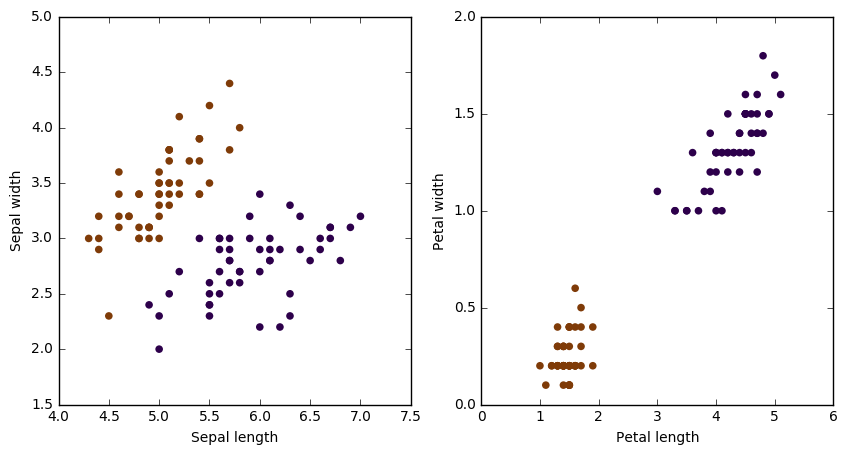

In [6]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]
print set(y_iris)

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [7]:
pred_iris = Clustering(k=2, linkage='complete').fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Constructed object of type Clustering with parameters: k = 2, linkage = complete
Fit end
Adjusted Rand index for iris is: 1.00


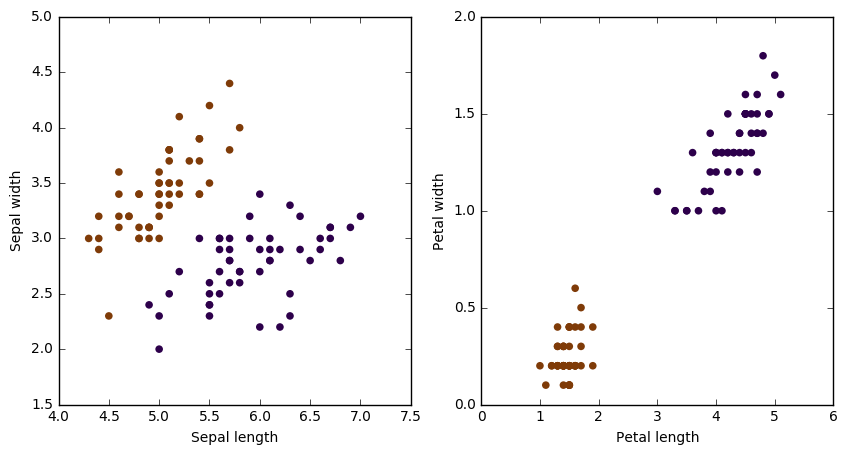

In [8]:
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [9]:
def quality(x, y):
    
    print 'Quality begin'
    
    labels = set(y)
    metrics = np.zeros(len(labels))
    nxt = 0
    for label in labels:
        indices = np.where(y == label)[0]
        length = len(indices)
        distances = ss.distance.cdist(x[indices], x[indices])
        metrics[nxt] = distances.max()
        nxt += 1
    
    print 'Quality end'
    return metrics.mean()

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [114]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k=k)
    y = cls.fit_predict(x_iris)
    criteria[i] = quality(x_iris, y)

Constructed object of type Clustering with parameters: k = 1, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 2, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 3, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 4, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 5, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 6, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 7, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 8, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 9, linkage = complete

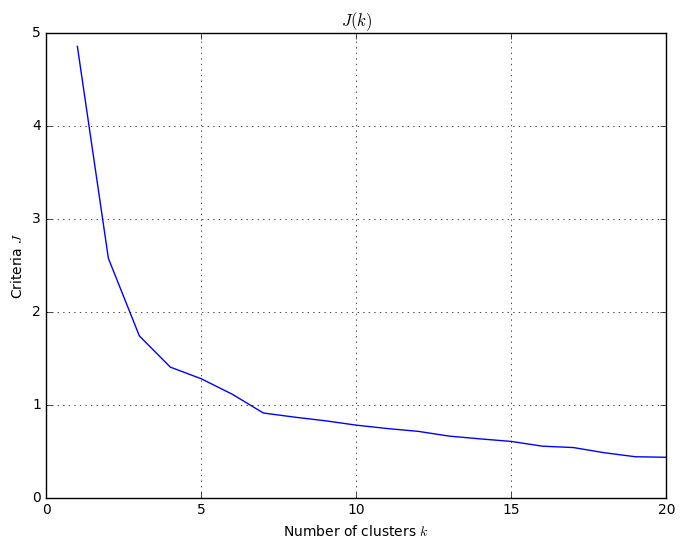

In [115]:
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

In [116]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k=k)
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Constructed object of type Clustering with parameters: k = 1, linkage = complete
Fit end
Quality begin
Quality end
Constructed object of type Clustering with parameters: k = 2, linkage = complete


KeyboardInterrupt: 

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [12]:
k = 5
cls = Clustering(k=k)
y = cls.fit_predict(x)

Constructed object of type Clustering with parameters: k = 5, linkage = complete
Fit end


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.054879
[t-SNE] Error after 100 iterations with early exaggeration: 1.042280
[t-SNE] Error after 375 iterations: 0.876070


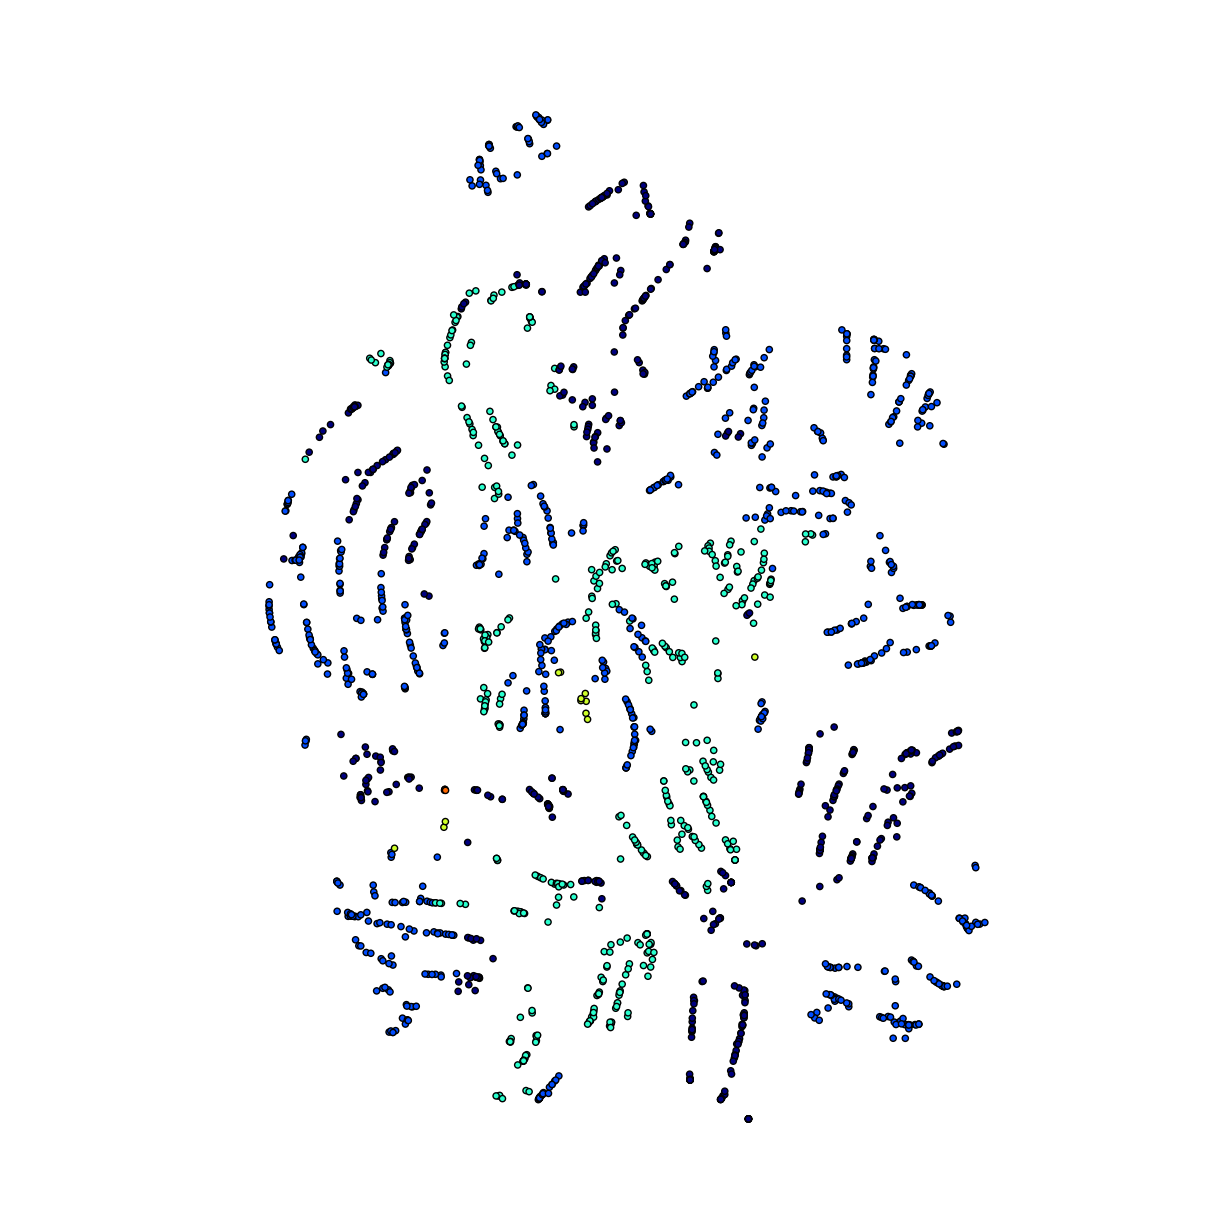

In [13]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

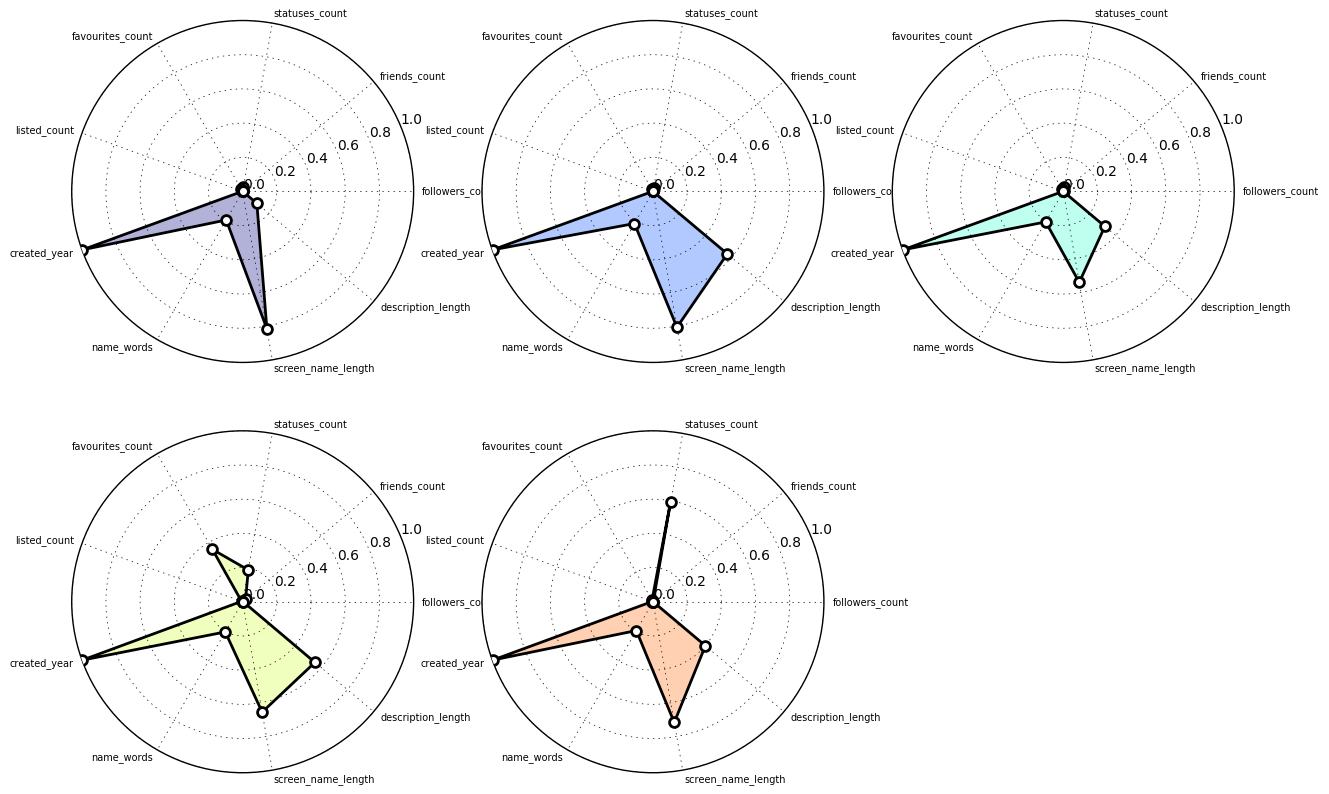

In [15]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.